In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   
print(torch.__version__)
!nvidia-smi -L

1.12.1+cu113
GPU 0: Tesla T4 (UUID: GPU-dfcb0185-6511-80e8-7eb9-4f5777102177)


In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomEqualize(),
        #transforms.GaussianBlur(5,sigma=(1,2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.RandomEqualize(),
        #transforms.GaussianBlur(5,sigma=(1, 2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

data_dir = '/content/gdrive/My Drive/paris0157@korea.ac.kr/Colab Notebooks/data/hymenoptera_data3'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(dataset_sizes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 400, 'val': 200}


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


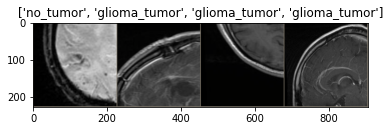

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [10]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4219 Acc: 0.8300
val Loss: 1.2900 Acc: 0.6450

Epoch 1/24
----------
train Loss: 0.2595 Acc: 0.8975
val Loss: 2.2004 Acc: 0.6000

Epoch 2/24
----------
train Loss: 0.3106 Acc: 0.8625
val Loss: 0.9706 Acc: 0.6750

Epoch 3/24
----------
train Loss: 0.2491 Acc: 0.9100
val Loss: 0.7897 Acc: 0.7450

Epoch 4/24
----------
train Loss: 0.1940 Acc: 0.9300
val Loss: 2.1238 Acc: 0.6750

Epoch 5/24
----------
train Loss: 0.2448 Acc: 0.9125
val Loss: 0.9838 Acc: 0.7200

Epoch 6/24
----------
train Loss: 0.2492 Acc: 0.8950
val Loss: 1.1300 Acc: 0.7200

Epoch 7/24
----------
train Loss: 0.1271 Acc: 0.9550
val Loss: 1.1207 Acc: 0.7100

Epoch 8/24
----------
train Loss: 0.1059 Acc: 0.9700
val Loss: 1.0395 Acc: 0.7350

Epoch 9/24
----------
train Loss: 0.1004 Acc: 0.9650
val Loss: 1.2709 Acc: 0.7050

Epoch 10/24
----------
train Loss: 0.0872 Acc: 0.9750
val Loss: 1.6113 Acc: 0.6550

Epoch 11/24
----------
train Loss: 0.0702 Acc: 0.9775
val Loss: 1.6740 Acc: 0.6600

Ep

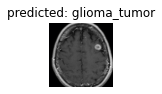

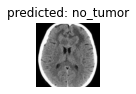

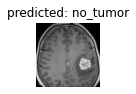

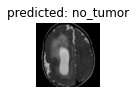

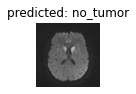

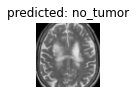

In [12]:
visualize_model(model_ft)

In [13]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6586 Acc: 0.6350
val Loss: 0.6321 Acc: 0.6400

Epoch 1/24
----------
train Loss: 0.5916 Acc: 0.7200
val Loss: 0.6365 Acc: 0.6050

Epoch 2/24
----------
train Loss: 0.5649 Acc: 0.7250
val Loss: 0.7347 Acc: 0.5450

Epoch 3/24
----------
train Loss: 0.5024 Acc: 0.7800
val Loss: 0.7116 Acc: 0.5800

Epoch 4/24
----------
train Loss: 0.4681 Acc: 0.8375
val Loss: 0.7066 Acc: 0.5950

Epoch 5/24
----------
train Loss: 0.4127 Acc: 0.8575
val Loss: 0.6962 Acc: 0.6100

Epoch 6/24
----------
train Loss: 0.4389 Acc: 0.8200
val Loss: 0.5936 Acc: 0.6950

Epoch 7/24
----------
train Loss: 0.4170 Acc: 0.8250
val Loss: 0.6213 Acc: 0.6450

Epoch 8/24
----------
train Loss: 0.3981 Acc: 0.8500
val Loss: 0.5803 Acc: 0.7200

Epoch 9/24
----------
train Loss: 0.4302 Acc: 0.8350
val Loss: 0.7044 Acc: 0.6350

Epoch 10/24
----------
train Loss: 0.4266 Acc: 0.8150
val Loss: 0.6717 Acc: 0.6400

Epoch 11/24
----------
train Loss: 0.4218 Acc: 0.8225
val Loss: 0.6971 Acc: 0.6200

Ep

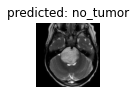

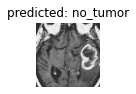

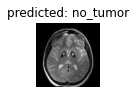

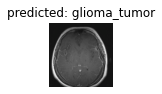

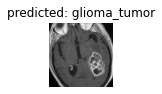

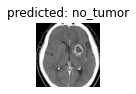

In [15]:
visualize_model(model_conv)

plt.ioff()
plt.show()